# Router

Control flow using LLMs: direct response or tool call based on input.

In [1]:
# API Keys
import os
from dotenv import load_dotenv

# Models
from langchain_openai import ChatOpenAI

# Messages
from langchain_core.messages import HumanMessage

# Graphs
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition # router
from IPython.display import Image, display
import pprint

# 1. Models

In [2]:
# OpenAI
load_dotenv(override=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "type-your-api-here")
gpt = "gpt-4o-mini"

# Ollama
OLLAMA_API_KEY = "ollama"
OLLAMA_BASE_URL = "http://localhost:11434/v1"
llama = "llama3.2:latest"

In [4]:
%%time
llm = ChatOpenAI(model=gpt, temperature=0.3)
# llm = ChatOpenAI(model=llama, temperature=0.3, api_key=OLLAMA_API_KEY, base_url=OLLAMA_BASE_URL)

llm.invoke("Hello there!")

CPU times: total: 3.19 s
Wall time: 20.5 s


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 10, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BgtJFAYRuLsm0RPLRwDVyNLhw7KaO', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--4775d970-e24c-4182-8331-1c7b2b54b94f-0', usage_metadata={'input_tokens': 10, 'output_tokens': 9, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# 2. Tools

In [5]:
def add(a: int, b: int):
    """Add b to a.

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int, b: int):
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b

def multiply(a: int, b: int):
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b: int):
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [6]:
tools = [add, subtract, multiply, divide]
llm_with_tools = llm.bind_tools(tools=tools)

In [7]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001CC174D7690>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001CC17952B50>, root_client=<openai.OpenAI object at 0x000001CC7F9B8310>, root_async_client=<openai.AsyncOpenAI object at 0x000001CC179526D0>, model_name='gpt-4o-mini', temperature=0.3, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add b to a.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'subtract', 'description': 'Subtract b from a.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'

# 3. Build the Graph

In [8]:
tools

[<function __main__.add(a: int, b: int)>,
 <function __main__.subtract(a: int, b: int)>,
 <function __main__.multiply(a: int, b: int)>,
 <function __main__.divide(a: int, b: int)>]

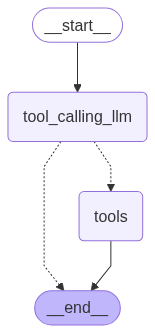

In [9]:
# Node functions
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)

# Nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

# If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
# If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END

# Testing

In [11]:
%%time

messages = [HumanMessage(content="How many 3 add 2, and then multiply it by 7!", name="Yusup")] # Hello, what is 3 add 7?
messages = graph.invoke({"messages": messages})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================
Name: Yusup

How many 3 add 2, and then multiply it by 7!
================================== Ai Message ==================================
Tool Calls:
  add (call_aIz94mHDcoEnfCKTsO9ptdO3)
 Call ID: call_aIz94mHDcoEnfCKTsO9ptdO3
  Args:
    a: 3
    b: 2
  multiply (call_kZ33JjXgCIcak63zvyN9vDrS)
 Call ID: call_kZ33JjXgCIcak63zvyN9vDrS
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

5
================================= Tool Message =================================
Name: multiply

35
CPU times: total: 31.2 ms
Wall time: 17.1 s
